<a href="https://colab.research.google.com/github/Iron486/NLP_emotions_classifier/blob/main/Bidirectional_LSTM_Conv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color='violet'>Import libraries</font>

In [1]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import statistics
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

### <font color='violet'>Load the preprocessed GloVe embeddings</font>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
filename = 'drive/My Drive/Colab Notebooks/NLP_emotions_dataset/Untitled Folder 1/emotions_dataset/embeddings_index.sav'
embeddings_index = pickle.load(open(filename, 'rb'))

### <font color='violet'>Import datasets and preprocess the datasets</font>

In [4]:

max_length = 58
f = open('drive/My Drive/Colab Notebooks/NLP_emotions_dataset/Untitled Folder 1/emotions_dataset/train.txt')
g=open('drive/My Drive/Colab Notebooks/NLP_emotions_dataset/Untitled Folder 1/emotions_dataset/val.txt')
h=open('drive/My Drive/Colab Notebooks/NLP_emotions_dataset/Untitled Folder 1/emotions_dataset/test.txt')


lb = LabelEncoder()
t = Tokenizer()
#def tokenizer_transform(words):
    #t.fit_on_texts(words)    
words_train =[]
labels=[]
for line in f:
    values =line.rsplit(";", maxsplit=1)
    sentence = values[0].split()
    label=values[1]#removesuffix('\n')
    word = sentence[:-1]
    words_train.append(word)
    labels.append(label)
f.close()  

t.fit_on_texts(words_train)
encoded_docs_train = t.texts_to_sequences(words_train)
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')


labels_train=lb.fit(labels)
labels_train=lb.transform(labels)


vocab_size = len(t.word_index) + 1
embedding_matrix_train = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[i] = embedding_vector

def Preprocessing(file,embeddings_index):
    words =[]
    labels=[]
    for line in file:
        values =line.rsplit(";", maxsplit=1)
        sentence = values[0].split()
        label=values[1]#.removesuffix('\n')
        word = sentence[:-1]
        words.append(word)
        labels.append(label)
    file.close()  
    # integer encode the documents
    encoded_docs = t.texts_to_sequences(words)
    #print(encoded_docs)
    # pad documents to a max length of8 words
    
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    
    labels=lb.transform(labels)
    
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    
    
    return padded_docs, encoded_docs, embedding_matrix,words,labels

#padded_docs_train, encoded_docs_train,embedding_matrix_train,words_train,labels_train=Preprocessing(f,embeddings_index)
padded_docs_val, encoded_docs_val,embedding_matrix_val,words_val,labels_val=Preprocessing(g,embeddings_index)
padded_docs_test, encoded_docs_test,embedding_matrix_test,words_test,labels_test=Preprocessing(h,embeddings_index)

In [5]:
# embedding_matrix
#t.word_index.items()
#words

In [6]:
len(padded_docs_train[3333])
set(labels)

{'anger\n', 'fear\n', 'joy\n', 'love\n', 'sadness\n', 'surprise\n'}

### <font color='violet'>Train the model</font>

In [13]:
tf.random.set_seed(79)
# define model
model = keras.Sequential()
#(14185, 100) shape dimension
model.add(keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix_train], input_length=max_length, trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,input_shape=(embedding_matrix_train.shape[0],embedding_matrix_train.shape[1]),return_sequences=True)))
model.add(keras.layers.Dropout(rate=0.1))
#put return_sequences=True if you put the 
#LSTM layer before Conv1d or before another LSTM layer
#model.add(keras.layers.Flatten()) #insert this to pass from MaxPooling to Fully connected neural network without GlobalAveragePooling1d
#model.add(tf.keras.layers.GlobalAveragePooling1D()) 
model.add(tf.keras.layers.Conv1D(32, 6, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.GlobalAveragePooling1D()) 
model.add(keras.layers.Dense(40,activation='elu'
                  ,kernel_initializer='GlorotNormal'
               #  ,kernel_regularizer=keras.regularizers.l2(0.02)
                 ))
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(17,activation='elu',kernel_initializer='GlorotNormal'
                ))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Dense(6,activation='sigmoid'))
# compile the model
opt = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.88,beta_2=0.999)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=6,restore_best_weights=True)
history=model.fit(padded_docs_train, labels_train, epochs=70,validation_data=(padded_docs_val, labels_val),callbacks=[early_stopping_cb],batch_size=24)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_val, labels_val)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 58, 100)           1418500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 58, 100)          60400     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 58, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 32)            19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 32)           0         
 )                                                               
                                                                 
 global_average_pooling1d (G  (None, 32)              

### <font color='violet'> History plot </font>

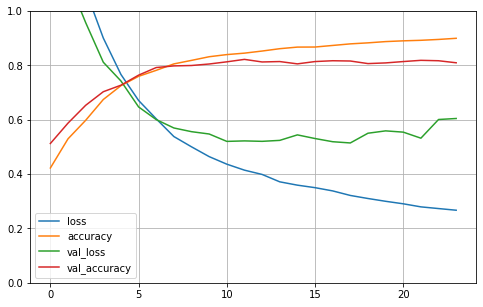

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
model.save('Conv1d_LSTM_bid_conv1d.h5')
#Accuracy: 81.60

### <font color='violet'>More details about the model</font>

In [15]:
model=keras.models.load_model('Conv1d_LSTM_bid_conv1d.h5') 
model.summary()

#to visualize activation functions
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
#info about optimizers
model.optimizer.get_config()        

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 58, 100)           1418500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 58, 100)          60400     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 58, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 32)            19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 32)           0         
 )                                                               
                                                                 
 global_average_pooling1d (G  (None, 32)              

{'amsgrad': False,
 'beta_1': 0.88,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.0004,
 'name': 'Adam'}